In [115]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def create_advisaral_image_using_FGSM(input_image, input_label, pretrained_model, epsilon=0.1):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adv_image = input_image + signed_grad * epsilon
    # clip adv_image from -1 to 1
    adv_image = tf.clip_by_value(adv_image, -1.0, 1.0)
    return adv_image

In [117]:
def create_advisaral_image_using_Gaussian_Noise(input_image, stddev):
    
    noise = tf.random.normal(shape=tf.shape(input_image), mean=0.0, stddev=stddev, dtype=input_image.dtype)
    noisy_image = input_image + noise

    noisy_image = tf.clip_by_value(noisy_image, -1, 1)
    
    return noisy_image

In [118]:
pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [119]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [120]:
# image are in root directory
image_path = 'baboon.jpg'
input_image = tf.io.read_file(image_path)
input_image = tf.image.decode_image(input_image)

In [121]:
processed_image = preprocess(input_image)
image_probs = pretrained_model.predict(processed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


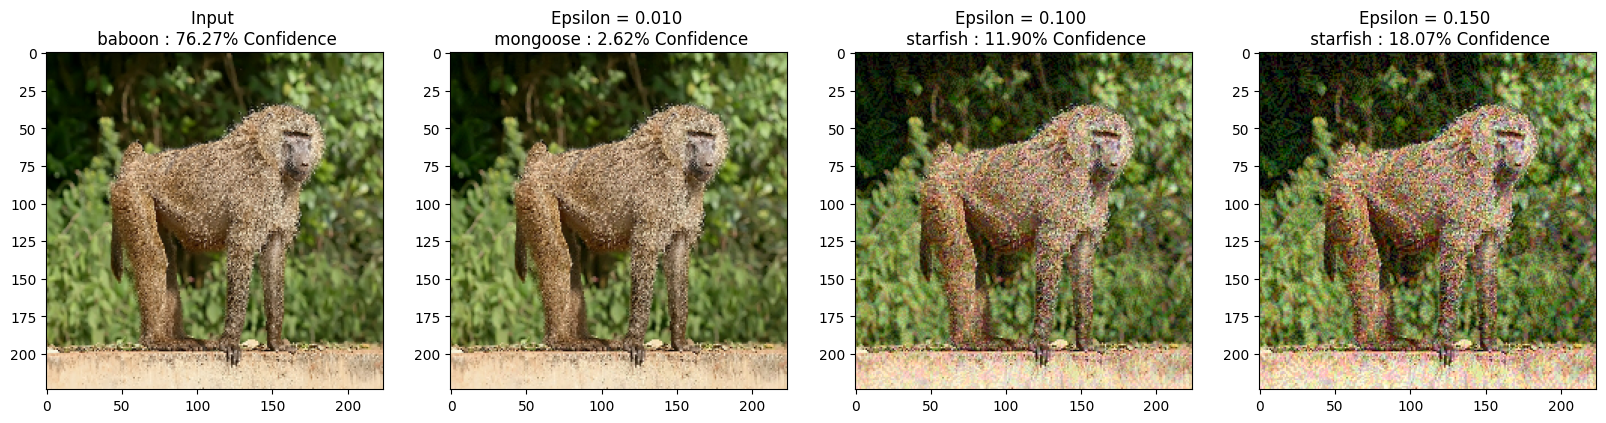

In [122]:
baboon_index = 372
input_label = tf.one_hot(baboon_index, depth=1000)
input_label = tf.reshape(input_label, (1, 1000))

epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

plt.figure(figsize=(20, 8))
for eps in epsilons:
    # Create adversarial image using FGSM
    adv_image = create_advisaral_image_using_FGSM(processed_image, input_label, pretrained_model, epsilon=eps)
    plt.subplot(1, len(epsilons), epsilons.index(eps) + 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_image))
    plt.imshow(adv_image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[epsilons.index(eps)],
                                                    label, confidence*100))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


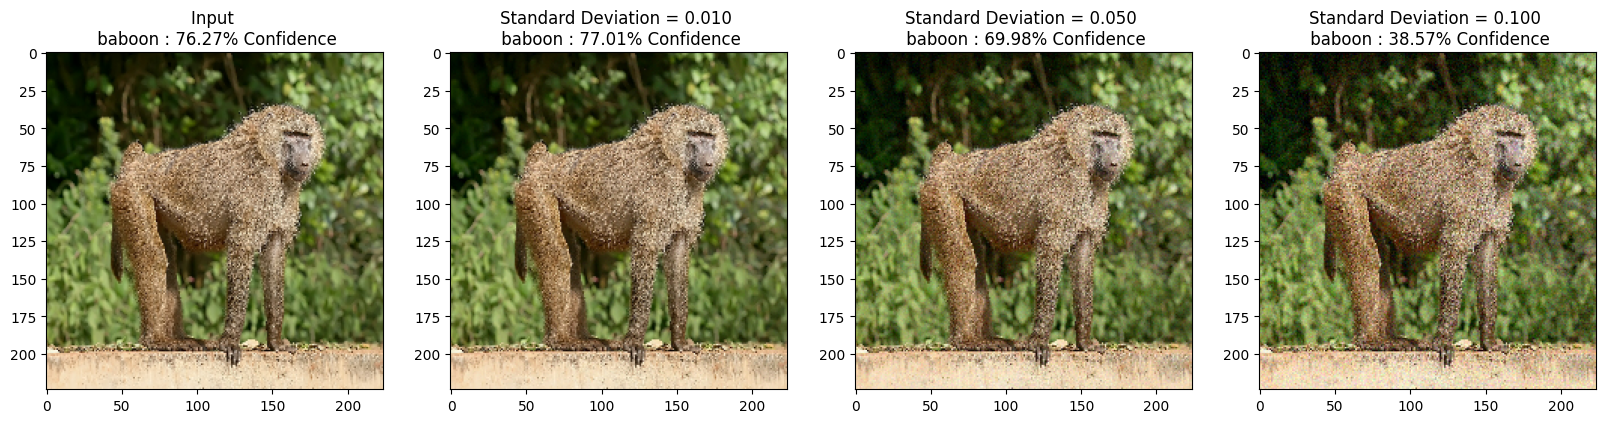

In [123]:
# Using Gaussian Noise
stddevs = [0, 0.01, 0.05, 0.1]
descriptions = [('Standard Deviation = {:0.3f}'.format(std) if std else 'Input')
                for std in stddevs]

plt.figure(figsize=(20, 8))
for std in stddevs:
    # Create adversarial image using Gaussian Noise
    adv_image = create_advisaral_image_using_Gaussian_Noise(processed_image, stddev=std)
    plt.subplot(1, len(stddevs), stddevs.index(std) + 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_image))
    plt.imshow(adv_image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[stddevs.index(std)],
                                                    label, confidence*100))

plt.show()